In [2]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
import os  
import sys  
sys.path.insert(0, os.getenv('HOME')+'/pycode/MscThesis/')
# sys.path.insert(0,r'C:\Users\coren\Documents\PhD\Code\AMFtrack')

import pandas as pd
from amftrack.util.sys import get_dates_datetime, get_dirname, temp_path, get_data_info, update_plate_info, \
get_current_folders, get_folders_by_plate_id


import ast
from amftrack.plotutil import plot_t_tp1
from scipy import sparse
from datetime import datetime
import pickle
import scipy.io as sio
from pymatreader import read_mat
from matplotlib import colors
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import frangi
from skimage import filters
from random import choice
import scipy.sparse
import os
from amftrack.pipeline.functions.image_processing.extract_graph import from_sparse_to_graph, generate_nx_graph, sparse_to_doc
from skimage.feature import hessian_matrix_det
from amftrack.pipeline.functions.image_processing.experiment_class_surf import Experiment
from amftrack.pipeline.functions.image_processing.node_id import (
    orient,reconnect_degree_2, first_identification, relabel_nodes_downstream,reduce_labels
)
import itertools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
directory = directory_project
all_folders = get_current_folders(directory)
folders = all_folders.loc[all_folders['Plate']=="808"]


In [3]:
folders

,total_path,Plate,PrincePos,root,strain,medium,split,Pbait,CrossDate,Temperature,...,/Analysis/skeleton_pruned_compressed.mat,/Analysis/transform.mat,/Analysis/transform_corrupt.mat,/Analysis/skeleton_realigned_compressed.mat,/Analysis/nx_graph_pruned.p,/Analysis/nx_graph_pruned_width.p,/Analysis/nx_graph_pruned_labeled.p,date,folder,Temp
8432,/projects/0/einf914/data/20211003_1937_Plate35,808,35,'Carrot','A5','001P100N','Y','-',20210928,NaN,...,True,True,False,True,True,True,True,"03.10.2021, 19:37:",20211003_1937_Plate35,NaN
8491,/projects/0/einf914/data/20211001_0003_Plate35,808,35,'Carrot','A5','001P100N','Y','-',20210928,NaN,...,True,True,False,True,True,True,True,"01.10.2021, 00:03:",20211001_0003_Plate35,NaN
8519,/projects/0/einf914/data/20211003_1737_Plate35,808,35,'Carrot','A5','001P100N','Y','-',20210928,NaN,...,True,True,False,True,True,True,True,"03.10.2021, 17:37:",20211003_1737_Plate35,NaN
8598,/projects/0/einf914/data/20211004_1135_Plate35,808,35,'Carrot','A5','001P100N','Y','-',20210928,NaN,...,True,True,False,True,True,True,True,"04.10.2021, 11:35:",20211004_1135_Plate35,NaN
8599,/projects/0/einf914/data/20211004_2137_Plate35,808,35,'Carrot','A5','001P100N','Y','-',20210928,NaN,...,True,True,False,True,True,True,True,"04.10.2021, 21:37:",20211004_2137_Plate35,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11028,/projects/0/einf914/data/20211005_1736_Plate35,808,35,'Carrot','A5','001P100N','Y','-',20210928,NaN,...,True,True,False,True,True,True,True,"05.10.2021, 17:36:",20211005_1736_Plate35,NaN
11032,/projects/0/einf914/data/20211005_0337_Plate35,808,35,'Carrot','A5','001P100N','Y','-',20210928,NaN,...,True,True,False,True,True,True,True,"05.10.2021, 03:37:",20211005_0337_Plate35,NaN
11061,/projects/0/einf914/data/20210930_0352_Plate35,808,35,'Carrot','A5','001P100N','Y','-',20210928,NaN,...,True,True,False,True,True,True,True,"30.09.2021, 03:52:",20210930_0352_Plate35,NaN
11102,/projects/0/einf914/data/20211011_0816_Plate35,808,35,'Carrot','A5','001P100N','Y','-',20210928,NaN,...,True,True,False,True,True,True,True,"11.10.2021, 08:16:",20211011_0816_Plate35,NaN


In [4]:
folder_list = list(folders["folder"])
folder_list.sort()

In [5]:
nx_graph_pos = []
for i, directory_name in enumerate(folder_list[0:2]):
    print(i)
    path_snap = directory + directory_name
    path_save = path_snap + "/Analysis/nx_graph_pruned_width.p"
    nx_graph_pos.append(pickle.load(open(path_save, "rb")))

0
1


In [6]:
def find_closest_edge(tip, Sedge,nx_graph_t,pos_t,nx_graph_tm1,pos_tm1):
    mini1 = np.inf
    posanchor = pos_tm1[tip]
    window = 1000
    potential_surrounding_t = Sedge[
        max(0, posanchor[0] - 2 * window) : posanchor[0] + 2 * window,
        max(0, posanchor[1] - 2 * window) : posanchor[1] + 2 * window,
    ]
    mini = np.inf
    for node_root in potential_surrounding_t.data:
        for edge in nx_graph_t.edges(int(node_root)):
            pixel_list = nx_graph_t.get_edge_data(*edge)["pixel_list"]
            if (
                np.linalg.norm(np.array(pixel_list[0]) - np.array(pos_tm1[tip]))
                <= 5000
            ):
                distance = np.min(
                    np.linalg.norm(
                        np.array(pixel_list) - np.array(pos_tm1[tip]), axis=1
                    )
                )
                if distance < mini:
                    mini = distance
                    right_edge = edge
    if mini == np.inf:
        print(f"didnt find a tip to match tip in pos {posanchor}")
        return(None,None,None,None)
    origin = np.array(
        orient(
            nx_graph_tm1.get_edge_data(*list(nx_graph_tm1.edges(tip))[0])[
                "pixel_list"
            ],
            pos_tm1[tip],
        )
    )
    origin_vector = origin[0] - origin[-1]
    branch = np.array(
        orient(
            nx_graph_t.get_edge_data(*right_edge)["pixel_list"],
            pos_t[right_edge[0]],
        )
    )
    candidate_vector = branch[-1] - branch[0]
    dot_product = np.dot(origin_vector, candidate_vector)
    if dot_product >= 0:
        root = right_edge[0]
        next_node = right_edge[1]
    else:
        root = right_edge[1]
        next_node = right_edge[0]
    last_node = root
    current_node = next_node
    last_branch = np.array(
        orient(
            nx_graph_t.get_edge_data(root, next_node)["pixel_list"],
            pos_t[current_node],
        )
    )
    return(last_node, next_node,last_branch,current_node)

In [7]:
def track(tip,current_node,last_branch,last_node,length_id,nx_graph_t,pos_t,nx_graph_tm1,pos_tm1,corresp_tips,ambiguous):
    i = 0
    loop = []
    while (
        nx_graph_t.degree(current_node) != 1
        and not current_node in nx_graph_tm1.nodes
    ):  # Careful : if there is a cycle with low angle this might loop indefinitely but unprobable
        i += 1
        if i >= 100:
            print(
                "identified infinite loop",
                i,
                tip,
                current_node,
                pos_t[current_node],
            )
            break
        mini = np.inf
        origin_vector = (
            last_branch[0] - last_branch[min(length_id, len(last_branch) - 1)]
        )
        unit_vector_origin = origin_vector / np.linalg.norm(origin_vector)
        candidate_vectors = []
        for neighbours_t in nx_graph_t.neighbors(current_node):
            if neighbours_t != last_node:
                branch_candidate = np.array(
                    orient(
                        nx_graph_t.get_edge_data(current_node, neighbours_t)[
                            "pixel_list"
                        ],
                        pos_t[current_node],
                    )
                )
                candidate_vector = (
                    branch_candidate[min(length_id, len(branch_candidate) - 1)]
                    - branch_candidate[0]
                )
                unit_vector_candidate = candidate_vector / np.linalg.norm(
                    candidate_vector
                )
                candidate_vectors.append(unit_vector_candidate)
                dot_product = np.dot(unit_vector_origin, unit_vector_candidate)
                angle = np.arccos(dot_product)
                if angle < mini:
                    mini = angle
                    next_node = neighbours_t
        #                     print('angle',dot_product,pos_t[last_node],pos_t[current_node],pos_t[neighbours_t],angle/(2*np.pi)*360)
        #!!!bug may happen here if two nodes are direct neighbours : I would nee to check further why it the case, optimal segmentation should avoid this issue.
        # This is especially a problem for degree 4 nodes. Maybe fuse nodes that are closer than 3 pixels.
        # Update on comment above, the fusing has been done. However the current tracking methodology may fail for short edges.
        if i >= 100:
            print(mini / (2 * np.pi) * 360, pos_t[next_node])
            if next_node in loop:
                break
            else:
                loop.append(next_node)
        assert len(candidate_vectors) >= 2,"candidate_vectors < 2"
        edge_couples = itertools.combinations(candidate_vectors, 2)
        competitor = np.max([np.arccos(np.dot(candidate_vectors[0], -candidate_vectors[1])) for candidate_vectors in edge_couples])
        #Look if the continuation is indeed best, including the case of degree 4 or more. This is a difficult ambiguous case. Handling is what it is
                            #Then candidate vectors is longer than 2.
        if mini < competitor:
            current_node, last_node = next_node, current_node
        else:
            break
    if current_node in nx_graph_tm1.nodes:
        if last_node not in nx_graph_tm1.nodes:
            if last_node in corresp_tips.values():
                ambiguous.add(tip)
            corresp_tips[tip] = last_node
    else:
        if current_node in corresp_tips.values():
            ambiguous.add(tip)
        corresp_tips[tip] = current_node
    return(ambiguous,corresp_tips)

In [8]:
def handle_ambiguous(ambiguous,corresp_tips,pos_tm1,pos_t):
    while len(ambiguous) > 0:  # improve ambiguity resolving!
        node = ambiguous.pop()
        identifier = corresp_tips[node]
        candidates = [
            nod for nod in corresp_tips.keys() if corresp_tips[nod] == identifier
        ]
        mini = np.inf
        for candidate in candidates:
            distance = np.linalg.norm(pos_tm1[candidate] - pos_t[identifier])
            if distance < mini:
                right_candidate = candidate
                mini = distance
        for candidate in candidates:
            if candidate != right_candidate:
                corresp_tips.pop(candidate)
                ambiguous.discard(candidate)
    return(corresp_tips)

In [9]:

def second_identification(
    nx_graph_tm1,
    nx_graph_t,
    pos_tm1,
    pos_t,
    length_id=200,
    tolerance=50,
):
    reconnect_degree_2(nx_graph_t, pos_t)
    reconnect_degree_2(nx_graph_tm1, pos_tm1)
    corresp, to_remove = first_identification(
        nx_graph_tm1, nx_graph_t, pos_tm1, pos_t, tolerance
    )
    downstream_graphs = [nx_graph_t]
    downstream_pos = [pos_t]
    new_graphs, new_poss = relabel_nodes_downstream(
        corresp, downstream_graphs, downstream_pos
    )
    pos_t = new_poss[0]
    nx_graph_t = new_graphs[0]
    downstream_pos = new_poss
    downstream_graphs = new_graphs
    corresp_tips = {node: node for node in corresp.keys()}
    tips = [node for node in nx_graph_tm1.nodes if nx_graph_tm1.degree(node) == 1]
    ambiguous = set()
    Sedge = sparse.csr_matrix((30000, 60000))
    for edge in nx_graph_t.edges:
        pixel_list = nx_graph_t.get_edge_data(*edge)["pixel_list"]
        pixela = pixel_list[0]
        pixelb = pixel_list[-1]
        Sedge[pixela[0], pixela[1]] = edge[0]
        Sedge[pixelb[0], pixelb[1]] = edge[1]
    for i, tip in enumerate(tips):
        last_node, next_node,last_branch,current_node = find_closest_edge(tip, Sedge,nx_graph_t,pos_t,nx_graph_tm1,pos_tm1)
        if last_node is None:
            continue
        ambiguous,corresp_tips = track(tip,current_node,last_branch,last_node,length_id,nx_graph_t,pos_t,nx_graph_tm1,pos_tm1,corresp_tips,ambiguous)
    corresp_tips = handle_ambiguous(ambiguous,corresp_tips,pos_tm1,pos_t)
    new_graphs, new_poss = relabel_nodes_downstream(
        corresp_tips, downstream_graphs, downstream_pos
    )

    downstream_pos = new_poss
    downstream_graphs = new_graphs
    new_graphs, new_poss = reduce_labels(
        [nx_graph_tm1] + downstream_graphs, [pos_tm1] + downstream_pos
    )
    return (new_graphs, new_poss)

In [10]:
nx_graph_tm1, nx_graph_t, pos_tm1, pos_t = nx_graph_pos[0][0],nx_graph_pos[1][0],nx_graph_pos[0][1],nx_graph_pos[1][1]

In [11]:
new_graphs, new_poss = second_identification(
    nx_graph_tm1,
    nx_graph_t,
    pos_tm1,
    pos_t,
    length_id=200,
    tolerance=50,
)

/home/cbisot/miniconda3/envs/amftrack/lib/python3.7/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


before ambiguities 318
didnt find a tip to match tip in pos [ 5849 33446]
didnt find a tip to match tip in pos [ 2413 37696]


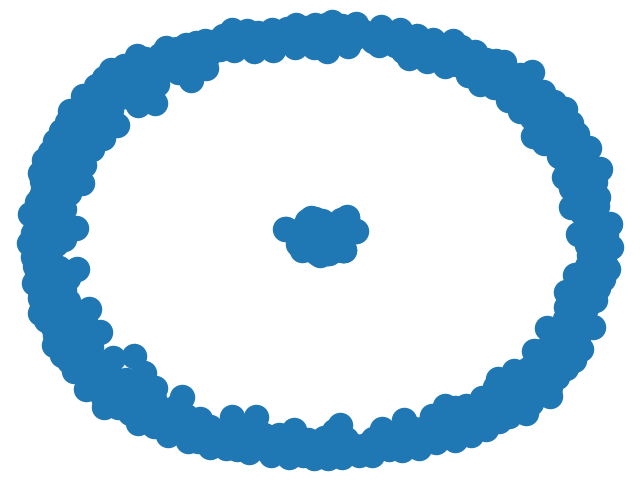

In [13]:
import networkx as nx
nx.draw(new_graphs[0])